# This work organized into 4 sections where represent my initial data exploration and work flow analysis. 


## Section 1: Data Visualization 
##### To gain some insight for the given data, results show that there are peak hour for the demand, coordinate with highest demand, different demand between the particular weekday or weekend in demand. 
## Section 2: Univariate time series modelling and forecasting
##### The univariate time series grouped the demand with mean regardless the geohash location and performed with adf-test and seasonal decompose, results show that the time series are stationary and seasonality. The AR model best fit the time series compared with other ARIMA/SARIMAX model in my experiments, thus it suggest that forecast demand are very much depend on it past values(lags), the larger the fit lags the better the accuracy, this is reasonable as human activity are roughly the same either in daily or weekly basic, so it past day demand such as previous day or the same particular day in last week could give a significant impact to today's forecast values.
## Section 3: Multivariate timeseries modelling with decoded geohash coordinate
##### When the given time series dependent variable are too big (geohash6), i try to reduce the variable number and found that after decoded the geohash the coordinate variable can be grouped into 116 variables . In short, 1329 geohash6 variables drop to 116 variables at the cost of 0.5km precision and so the modelling will perform faster, better accuracy and used less of memory. Thus if the 0.5km coordinates precision make no much significant impact in real life then it is really good approaches.
## Section 4: Modelling for multivariate timeseries modelling with geohash coordinate
##### As from the univariate time series modelling analysis, found that the time series work well with AR model rather than ARIMA/SARIMAX, thus i employ VAR model for this multivariate timeseries by assumed the Univariate time series share similar attribute with Multivariate time series as each geohash location demand are exploratory variable to the total demand(Univariate) in general.


# Section 1: Data Visualization for the given data to gain some insight or intuition toward the data before going to modelling and forecasting step. 

In [1]:
import pandas as pd
import datetime as dt
import geohash as gh
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
%matplotlib inline
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
# Load specific forecasting tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
GrabVisual = pd.read_csv('GrabAssignment.csv')

In [3]:
GrabVisual['timestamp'] = pd.to_datetime(GrabVisual['timestamp'], format='%H:%M').dt.time

In [4]:
GrabVisual['Coordinate'] = GrabVisual.apply(lambda x: gh.decode(x.geohash6), axis=1)

In [5]:
GrabVisual['Latitude'] = GrabVisual.Coordinate.str[0]
GrabVisual['Longitude'] = GrabVisual.Coordinate.str[1]

In [6]:
GrabVisual.head()

,geohash6,day,timestamp,demand,Coordinate,Latitude,Longitude
0,qp03wc,18,20:00:00,0.020072,"(-5.35, 90.7)",-5.35,90.7
1,qp03pn,10,14:30:00,0.024721,"(-5.41, 90.7)",-5.41,90.7
2,qp09sw,9,06:15:00,0.102821,"(-5.33, 90.9)",-5.33,90.9
3,qp0991,32,05:00:00,0.088755,"(-5.35, 90.8)",-5.35,90.8
4,qp090q,15,04:00:00,0.074468,"(-5.41, 90.7)",-5.41,90.7


In [7]:
DemandDTS = GrabVisual.groupby(['day', 'timestamp'], as_index=False, sort=True).mean()

In [8]:
DemandDTS = DemandDTS.set_index(pd.date_range(datetime(1900, 1, 1, hour=0, minute=0), periods=5847, freq='15min'))

In [9]:
DemandDTS = DemandDTS.drop(['day','timestamp'], axis=1, inplace = False)

In [10]:
DemandDTS.iplot(mode='lines+markers+text',y='demand',opacity=0.5, size=2, xTitle='TimeStamp',yTitle='Demand',title='Relationship between timestamp and daily demand on consecutive day')

If you zoom in the graph to see each of the day trend, the trend for each day are quite stably repeated, thus the time factor are really impact to the demand and indicated a seasonality trend. In order obviously to see the demand trend within a particular day, i conduct another graph on below.

In [11]:
DemandTS = GrabVisual.groupby(['timestamp'],as_index=True, sort=True).mean()

In [12]:
DemandTS.iplot(mode='lines+markers+text',y='demand',opacity=0.8,xTitle='TimeStamp',yTitle='Demand',title='Relationship between timestamp and daily demand')

From graph, we can notice that demand gradually increase start from midnight and reach it peak on morning 10am. We can also deduce that person who arrive the city at midnight and to go for working office on the morning have most demand for Grab service. While we also can observe that people tend to go office with Grab but not for back to home from office after off duty. 

In [13]:
DemandCoordinate = GrabVisual.drop('day',axis=1, inplace = False)

In [14]:
DemandCoordinate = DemandCoordinate.groupby(['Latitude','Longitude'],as_index=False, sort=True).mean()

In [15]:
DemandCoordinate = DemandCoordinate.pivot(index='Latitude', columns='Longitude', values='demand')

In [16]:
DemandCoordinate.head()

Longitude,90.6,90.7,90.8,90.9,91.
Latitude,,,,,
-5.24,0.004986,0.015804,0.059021,0.052884,0.014024
-5.25,0.009468,0.034504,0.055285,0.053633,0.012740
-5.26,0.008854,0.017011,0.027496,0.033540,0.012106
-5.27,0.009865,0.033065,0.069711,0.087533,0.012872
-5.28,0.022348,0.050866,0.047529,0.116185,0.047088


In [17]:
figCoordinate = go.Figure(data=[go.Surface(z = DemandCoordinate.values, colorscale = 'Jet')], 
        layout=go.Layout(
        title='Relationship between Coordinate and Demand',
        autosize = False,
        width = 800,
        height = 800
        ))

In [18]:
iplot(figCoordinate)

Even though the Coordinate had anonymised, but from the Graph we can notice that coordinate (-5.32, 90.7) nearby have the highest demand while the second peak coordinate are nearby (-5.36, 90.8). Thus Grab driver can standby on these loations for their passenger.

In [19]:
DemandDay = GrabVisual.groupby(['day'], as_index=False, sort=True).mean()

In [20]:
DemandDay = DemandDay.set_index("day", drop = False)

In [21]:
DemandDay.head()

,day,demand
day,,
1,1,0.093651
2,2,0.109683
3,3,0.108904
4,4,0.120707
5,5,0.094623


In [22]:
DemandDay.iplot(mode='lines+markers+text',y='demand',opacity=0.8,xTitle='Consecutive Day',yTitle='Demand',title='Relationship between consecutive day and demand')

From the graph so far hard to deduce any significant things yet but the time series trend look like stationary and show a seasonality which probably in a week period. To further check for their relationship, i try seperate the day into particular weekday and weekend by assuming that the given data Day 1 is Monday.

In [23]:
DemandVSD = GrabVisual.groupby(['day', 'timestamp'], as_index=False, sort=True).mean()

In [24]:
DemandVSD = DemandVSD.set_index(pd.date_range(datetime(1900, 1, 1, hour=0, minute=0), periods=5847, freq='15min'))

In [25]:
DemandVSD['Weekday'] = DemandVSD.index.weekday_name

In [26]:
DemandVSD = DemandVSD.groupby(['Weekday'], as_index=False, sort=True).mean().drop('day', axis = 1, inplace=False)

In [27]:
DemandVSD

,Weekday,demand
0,Friday,0.089207
1,Monday,0.094420
2,Saturday,0.082087
3,Sunday,0.094060
4,Thursday,0.104880
5,Tuesday,0.099293
6,Wednesday,0.101692


In [28]:
Weekdaytrace = {'type':'scatter','x': DemandVSD['Weekday'],'y': DemandVSD['demand'],'name': 'Weekday','mode': 'lines'}

In [29]:
DayTraceData = [Weekdaytrace]
DayTraceLayout = {'title': 'Compare the Demand between particular weekday and weekend', 'xaxis' : {'title':'Weekday and Weekend'}, 'yaxis': {'title': 'Demand'}}
DayTraceFig = dict(data=DayTraceData, layout=DayTraceLayout)
iplot(DayTraceFig)

From the graph, we can find that Thursday are significantly High demand in average compare to other day. While the Saturday are significantly Low demand in average compare to other day in long term average. 

Thus from there we might deduce that the demand not only show seasonality within the timestamp in a day, but also seasonal in a particular weekday or weekend attribute. 

The results surprisingly show that Friday, Saturday and Sunday are actually low demand for the Grab riding services, while Tuesday, Wednesday and Thursday have significantly high demand for the riding services.  

**The weekend and weekday trend probably will be more obvious if given data are more larger such as 1 year data.

# Section 2 : Univariate Timeseries Modelling to forecast the demand regardless the geohash coordinate
###  As the demand on each location explanatory to the total demand in day and time, the best fit model for the total demand may also perform well on each location demand as they might share the same attribute, also to easier to process to perform statistical analysis to the demand data

In [30]:
GrabUni = pd.read_csv('GrabAssignment.csv')

In [31]:
GrabUni['timestamp'] = pd.to_datetime(GrabUni['timestamp'], format='%H:%M').dt.time

In [32]:
TimesDayDemand = GrabUni.groupby(['day', 'timestamp'], as_index=False, sort=True).mean()

In [33]:
TimesDayDemand = TimesDayDemand.set_index(pd.date_range(datetime(1900, 1, 1, hour=0, minute=0), periods=5847, freq='15min'))

In [34]:
TimesDayDemand = TimesDayDemand.drop(['day','timestamp'], axis=1, inplace = False)

In [35]:
TimesDayDemand.head()

,demand
1900-01-01 00:00:00,0.050461
1900-01-01 00:15:00,0.051678
1900-01-01 00:30:00,0.054018
1900-01-01 00:45:00,0.057015
1900-01-01 01:00:00,0.061216


## Statistical Test for the Univariate time series

In [36]:
# Test for stationarity_Augmented Dickey-Fuller test, A test for stationarity
def stationarity_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dicket-Fuller Test:")
    df_test = adfuller(timeseries.iloc[:,0].values, autolag = "AIC", maxlag = None)
    df_output = pd.Series(df_test[0:4],
                         index = ["Test Statistic","p-value", "Number of lags used","Number of observations used"])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)

In [37]:
stationarity_test(TimesDayDemand)

Results of Dicket-Fuller Test:
Test Statistic                -1.495165e+01
p-value                        1.277713e-27
Number of lags used            3.400000e+01
Number of observations used    5.812000e+03
Critical Value (1%)           -3.431476e+00
Critical Value (5%)           -2.862037e+00
Critical Value (10%)          -2.567035e+00
dtype: float64


Result show p-value are actually extreme small which conclude that the time series are stationary, which are good to proceed and need to differencing.

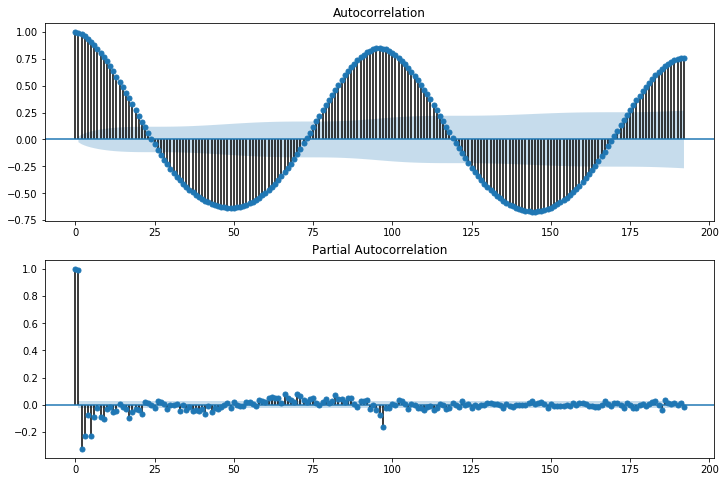

In [38]:
# Importing ACF and PACF plot functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))
plot_acf(TimesDayDemand, lags = 192, ax = ax1)
plot_pacf(TimesDayDemand, lags = 192, method='ywm' or 'ywmle', ax = ax2);

As we can see the seosonal cycle are almost 96 lags from ACF graph, which is very reasonable as 96 lags for 15mins frequency are a cycle of a Day.

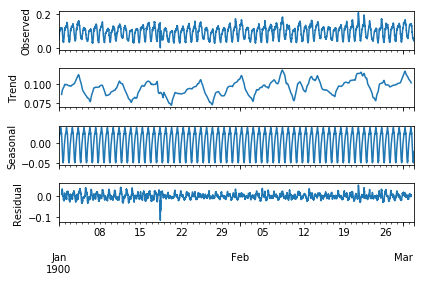

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(TimesDayDemand['demand'], model='additive', freq =96)
result.plot();

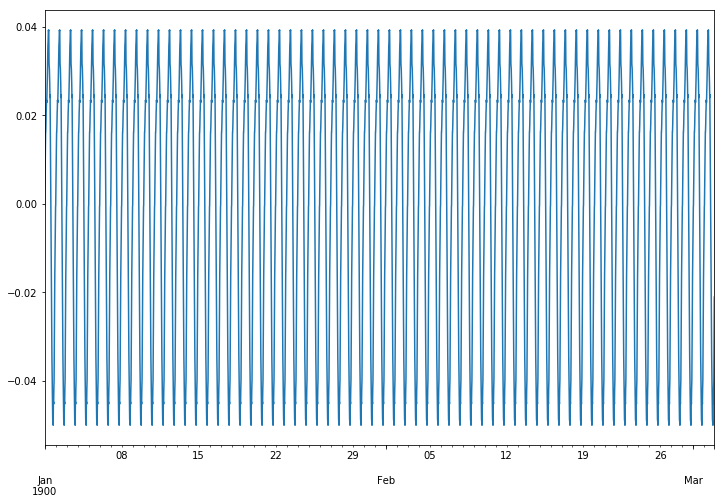

In [40]:
result.seasonal.plot(figsize=(12,8))

The ETS_decomposition result also indicated a very strong seasonal properties on the time series with 96 lags.

In [41]:
#Simple rolling calculation with minimum number of periods for window
def plot_rolling(timeseries, window):
    rol_mean = timeseries.rolling(window, min_periods = 1).mean()
    rol_std = timeseries.rolling(window, min_periods = 1).std()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rol_mean, color = "red", label = "Rolling Mean")
    std = plt.plot(rol_std, color = "black", label = "Rolling Std")
    plt.legend(loc = 'best')
    plt. title("Rolling Mean and Standard Deviation (window = "+str(window)+")")
    plt.show()

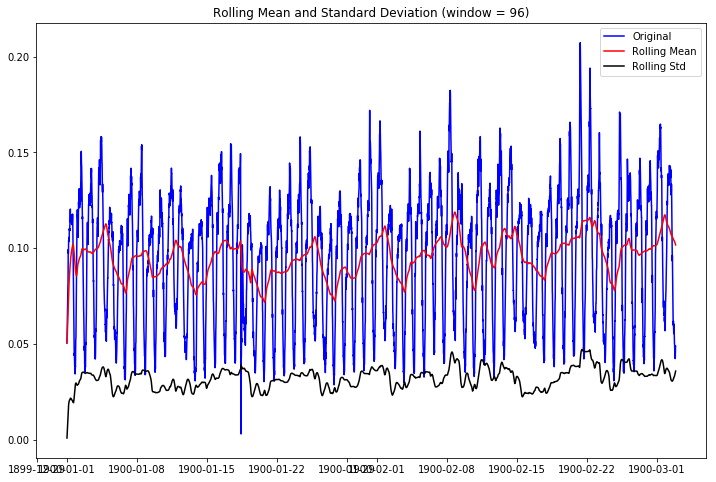

In [42]:
plot_rolling(TimesDayDemand, 96)

In [43]:
#Exponentially weighted moving average

def plot_ewma(timeseries, alpha):
    expw_ma = timeseries.ewm(alpha = alpha).mean()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    exwm = plt.plot(expw_ma, color = "red", label = "EWMA")
    plt.legend(loc = 'best')
    plt. title("EWMA (alpha = "+str(alpha)+")")
    plt.show()

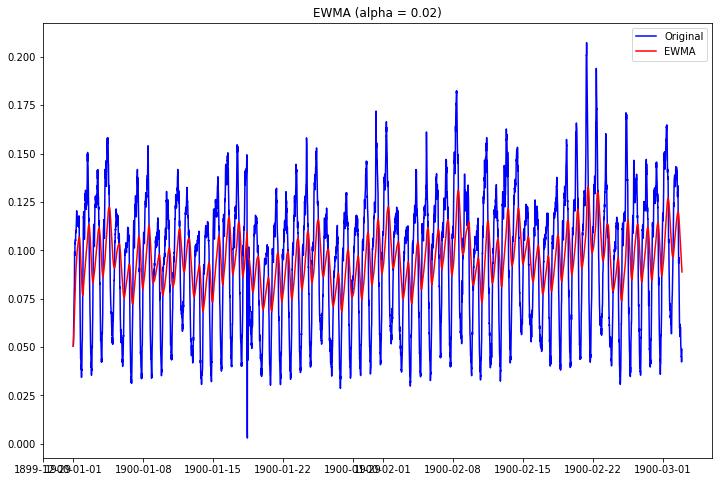

In [44]:
plot_ewma(TimesDayDemand, 0.02)

## Fitting the univariate time series with AR model 
#### Split the data into train-test set, and the test data set to be a cycle of week which is 672 periods with 15 mins frequency
#### Results show that this time series well fit AR model with 672 lags, results show AIC = -11.17 and RMSE = 0.0118 compare to test set.
#### This also can conclude that the demand are periodical and very much depend on it lags (past value) to forecast a current demand.

In [45]:
nobs=672
train, test = TimesDayDemand[0:-nobs], TimesDayDemand[-nobs:]

In [46]:
model = AR(train.demand)
ARfit = model.fit(maxlag=672)

In [47]:
start = len(train)
end = len(train) + len(test) -1

In [48]:
test_predictions = ARfit.predict(start=start, end=end)

In [49]:
ARfit.aic

-11.106778328546527

In [50]:
test.mean()

demand    0.099879
dtype: float64

In [51]:
np.sqrt(mean_squared_error(test,test_predictions))

0.011813581863763745

#### Let's perform analysis for the fitted model residual properties
At the end, Results shows that the model residual are stationary and normal distributed, mean close to zero which is a good indication for the forecasting

In [52]:
np.mean(ARfit.resid)

-9.092616856102427e-16

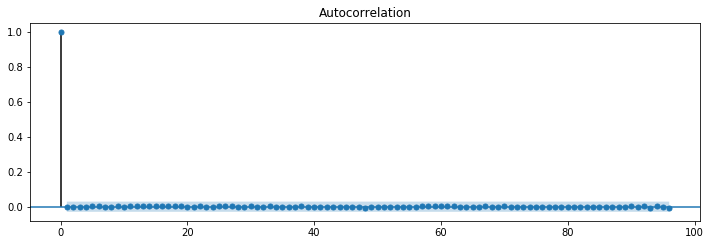

In [53]:
# ACF plot to test for autocorrelation for fitted model residual
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ARfit.resid, lags=96, ax=ax1)

In [54]:
# Custom function to tet for a normal distribution
def resid_histogram(data):
    import matplotlib.pyplot as plt
    from numpy import linspace
    from scipy.stats import norm
    
    plt.figure(figsize=(10,6))
    plt.hist(data, bins = 'auto', density = True, rwidth = 0.85, label = 'Residuals')
    mean_resid, std_resid = norm.fit(data)
    xmin, xmax = plt.xlim()
    curve_length = linspace(xmin, xmax, 100)
    bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
    plt.plot(curve_length, bell_curve, 'm', linewidth = 2)
    plt.grid(axis='y', alpha = 0.2)
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Residuals vs Normal Distribution - Mean = '+str(mean_resid)+', Std = '+str(std_resid)+'')
    plt.show()

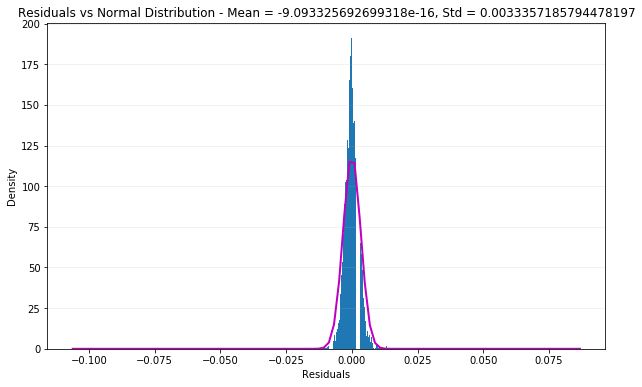

In [55]:
resid_histogram(ARfit.resid)

In [56]:
# Test for stationarity_Augmented Dickey-Fuller test, A test for stationarity
def stationarity_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dicket-Fuller Test:")
    df_test = adfuller(timeseries.values, autolag = "AIC", maxlag = None)
    df_output = pd.Series(df_test[0:4],
                         index = ["Test Statistic","p-value", "Number of lags used","Number of observations used"])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)

In [57]:
stationarity_test(ARfit.resid)

Results of Dicket-Fuller Test:
Test Statistic                  -67.246581
p-value                           0.000000
Number of lags used               0.000000
Number of observations used    4502.000000
Critical Value (1%)              -3.431803
Critical Value (5%)              -2.862182
Critical Value (10%)             -2.567112
dtype: float64


#### Graph to visualise the forecast results compare with the test dataset

In [58]:
traintrace = {'type':'scatter','x': train.index ,'y': train.demand,'name': 'train','mode': 'lines'}
testtrace = {'type':'scatter','x': test.index, 'y': test.demand,'name': 'test','mode': 'lines'}
Fcasttrace = {'type':'scatter','x': test_predictions.index, 'y': test_predictions,'name': 'test_predictions','mode': 'lines'}

In [59]:
TraceData = [traintrace, testtrace, Fcasttrace]
TraceLayout = {'title': 'Compare the demand between test and forecasted data', 'xaxis' : {'title':'Sequential day and time order'}, 'yaxis': {'title': 'Demand'}}
TraceFig = dict(data=TraceData, layout=TraceLayout)
iplot(TraceFig)

#### Try to fit the time series in another model such as ARIMA, SARIMAX and compare whether the model will perform better than AR model in term of RMSE, but at the end all the other model perform weaker than AR model in term of AIC and RMSE in my experiment.



In [60]:
stepwise_fit = auto_arima(TimesDayDemand['demand'], start_p=0, start_q=0,
                          max_p=10, max_q=10,
                          seasonal=True,
                          d=None, trace=True,stepwise=True)           

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-47143.366, BIC=-47130.019, Fit time=1.337 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-47829.742, BIC=-47809.721, Fit time=1.101 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-47591.916, BIC=-47571.896, Fit time=0.759 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-48140.052, BIC=-48113.358, Fit time=0.927 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-48196.395, BIC=-48163.027, Fit time=2.523 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-48344.215, BIC=-48297.500, Fit time=2.905 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-48339.027, BIC=-48298.986, Fit time=3.560 seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-48473.639, BIC=-48420.251, Fit time=8.123 seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-48430.855, BIC=-48384.140, Fit time=3.169 seconds
F

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5847
Model:               SARIMAX(6, 1, 4)   Log Likelihood               24283.232
Date:                Sun, 08 Sep 2019   AIC                         -48542.465
Time:                        19:33:27   BIC                         -48462.382
Sample:                             0   HQIC                        -48514.618
                               - 5847                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.735e-06   3.89e-05     -0.122      0.903   -8.09e-05    7.14e-05
ar.L1          0.7375      0.230      3.202      0.001       0.286       1.189
ar.L2         -0.6322      0.182     -3.471      0.001      -0.989      -0.275
ar.L3          0.5207      0.095      5.506      0.000       0.335       0.706
ar.L4          0.2034      0.119      1.703      0.089      -0.031       0.437
ar.L5         -0.1297      0.037     -3.475      0.001      -0.203      -0.057
ar.L6          0.0846      0.032      2.673      0.008       0.023       0.147
ma.L1         -0.5234      0.230     -2.278      0.023      -0.974      -0.073
ma.L2          0.6880      0.138      4.991      0.000       0.418       0.958
ma.L3         -0.4870      0.103     -4.737      0.000      -0.689      -0.285
ma.L4          0.0116      0.124      0.094      0.925      -0.231       0.254
sigma2      1.441e-05   5.73e-08    251.664      0.000    1.43e-05    1.45e-05
===================================================================================
Ljung-Box (Q):                      189.37   Jarque-Bera (JB):           7064445.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                       173.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
model1 = ARIMA(train['demand'],order=(6,1,4))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.demand   No. Observations:                 5174
Model:                 ARIMA(6, 1, 4)   Log Likelihood               21437.478
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 08 Sep 2019   AIC                         -42850.957
Time:                        19:34:20   BIC                         -42772.340
Sample:                    01-01-1900   HQIC                        -42823.451
                         - 02-23-1900                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            5.18e-06      0.000      0.031      0.976      -0.000       0.000
ar.L1.D.demand     0.6960        nan        nan        nan         nan         nan
ar.L2.D.demand    -0.8693        nan        nan        nan         nan         nan
ar.L3.D.demand     0.5654        nan        nan        nan         nan         nan
ar.L4.D.demand     0.2887        nan        nan        nan         nan         nan
ar.L5.D.demand    -0.1311      0.011    -12.189      0.000      -0.152      -0.110
ar.L6.D.demand     0.1589      0.016      9.981      0.000       0.128       0.190
ma.L1.D.demand    -0.4897        nan        nan        nan         nan         nan
ma.L2.D.demand     0.9489        nan        nan        nan         nan         nan
ma.L3.D.demand    -0.4895        nan        nan        nan         nan         nan
ma.L4.D.demand    -0.0468        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1135           -0.0000j            1.1135           -0.0000
AR.2           -0.0004           -1.0001j            1.0001           -0.2501
AR.3           -0.0004           +1.0001j            1.0001            0.2501
AR.4           -1.6577           -0.0000j            1.6577           -0.5000
AR.5            0.6848           -1.7144j            1.8461           -0.1895
AR.6            0.6848           +1.7144j            1.8461            0.1895
MA.1           -0.0007           -1.0018j            1.0018           -0.2501
MA.2           -0.0007           +1.0018j            1.0018            0.2501
MA.3            1.7450           -0.0000j            1.7450           -0.0000
MA.4          -12.2117           -0.0000j           12.2117           -0.5000
-----------------------------------------------------------------------------
"""

In [62]:
start1=len(train)
end1=len(train)+len(test)-1
predictions1 = results1.predict(start=start1, end=end1, dynamic=False, typ='levels').rename('ARIMA(6,1,4) Predictions')

In [63]:
np.sqrt(mean_squared_error(test,predictions1))

0.05413979970077262

RMSE larger than AR(672) model and the visual graph for the forecasted trend shown as below:

In [64]:
traintrace = {'type':'scatter','x': train.index ,'y': train.demand,'name': 'train','mode': 'lines'}
testtrace = {'type':'scatter','x': test.index, 'y': test.demand,'name': 'test','mode': 'lines'}
Fcasttrace = {'type':'scatter','x': predictions1.index, 'y': predictions1,'name': 'predictions','mode': 'lines'}

In [65]:
TraceData = [traintrace, testtrace, Fcasttrace]
TraceLayout = {'title': 'Compare the demand between test and forecasted data', 'xaxis' : {'title':'Sequential day and time order'}, 'yaxis': {'title': 'Demand'}}
TraceFig = dict(data=TraceData, layout=TraceLayout)
iplot(TraceFig)

#### The ARIMA model (6,1,4) forecasting results are bad as shown in graph above, and had try fit other model by setting the period of seasonality but the results still bad and cost too much time to get the best parameters for model, so the exploration stop here.

# Section 3 : Multivariate Timeseries Modelling to forecast the demand with decoded geohash coordinate

### The main point here is i decoded the geohash coordinate so that the coordinate variable sharply drop to 116 instead of 1329 geohash coordinate. As we know the given geohash data is in 6 digits which it precision will down to 0.61km, while the decoded two decimals coordinate precision is around 1.1km. 
### In result, i reduce the coordinate variable from 1329 to 116 at the cost of 0.5km precision thus the modelling will perform faster, better accuracy, used less of memory to perform the VAR modelling

In [ ]:
Grab = pd.read_csv('GrabAssignment.csv')

In [ ]:
Grab['timestamp'] = pd.to_datetime(Grab['timestamp'], format='%H:%M').dt.time

In [ ]:
Grab['Coordinate'] = Grab.apply(lambda x: gh.decode(x.geohash6), axis=1)

In [ ]:
GrabRF = Grab.groupby(['Coordinate', 'day', 'timestamp'])['demand'].mean().unstack('Coordinate')

In [ ]:
GrabRF = GrabRF.set_index(pd.date_range(datetime(1900, 1, 1, hour=0, minute=0), periods=5847, freq='15min'))

In [ ]:
GrabRF = GrabRF.fillna(0)

In [ ]:
GrabRF.head()

In [ ]:
nobs=96
train, test = GrabRF[0:-nobs], GrabRF[-nobs:]

In [ ]:
model_VAR = VAR(train)
results_VAR = model_VAR.fit(672)    #Same as AR model lags number, as we know the more the lags the more it work well

In [ ]:
lagged_values_VAR = train.values[-672:]

In [ ]:
z = results_VAR.forecast(y=lagged_values_VAR, steps=96) 

In [ ]:
idx = pd.date_range(datetime(1900, 3, 1, hour=21, minute=45), periods=96, freq='15min')

In [ ]:
df_forecast_VAR = pd.DataFrame(z, index=idx, columns=test.columns)

In [ ]:
results_VAR.aic

In [ ]:
test.mean().sum()

In [ ]:
np.sqrt(mean_squared_error(test,z))

In [ ]:
df_forecast_VAR.iplot()
test.iplot()

In [ ]:
np.mean(results_VAR.resid).sum()

In [ ]:
forecast_values_VAR_672 = Final_results.forecast(y=lagged_values_VAR, steps=5)

# Section 4 : Multivariate Timeseries Modelling to forecast the demand with  geohash variables 

In [ ]:
Grab = pd.read_csv('GrabAssignment.csv')

In [ ]:
#Reset the timestamp in a proper time format
Grab['timestamp'] = pd.to_datetime(Grab['timestamp'], format='%H:%M').dt.time

In [ ]:
#Regroup data to make the day and timestamp in order and unstack geohash
GrabFull = Grab.groupby(['geohash6', 'day', 'timestamp'])['demand'].mean().unstack('geohash6')

In [ ]:
GrabFull.head()

In [ ]:
#Merge the consecutive day and timestamp into one time series with a assigned datetime and 15min frequency
GrabFull = GrabFull.set_index(pd.date_range(datetime(1900, 1, 1, hour=0, minute=0), periods=5847, freq='15min'))

In [ ]:
#I cut the full data and use 3 weeks times data to forecast the future
#As i think the next future week are more dependent to recently weeks activity rather than a long run time series
#The long-run time series may distort the demand and fail to reflect well for the demand change in weekly.
GrabHalf = GrabFull.iloc[-2016:]   

In [ ]:
#As there are NaN values in the data, thus i set it all to 0
#As i think the NaN occur because at that particular time there are no demand at all on the geohash locations,
#Thus set to 0 value i think is reasonable
GrabHalf = GrabHalf.fillna(0)

In [ ]:
#Let the test dataset be one week dataset as it is the cycle of weekday & weekend
nobs=672    
trainF = GrabHalf[0:-nobs]
testF = GrabHalf[-nobs:]

In [ ]:
#Make a minimum noise to the data, so that there are no constant variable on the time series , thus able to apply VAR
#Chosen diagonal +1 as it look behave like Identity matrix and also ensure there are no variable constant along the time series
#Dont run this twice**
np.fill_diagonal(trainF.values, trainF + 1)

In [ ]:
#Fit the VAR lag = 14 as the challenge mention features of up to 14 consecutive days
#In fact from the Section 3 knowledge, we know that the larger the lags the better the performance in forecast 
model_VAR_F = VAR(trainF) 
results_VAR_F = model_VAR_F.fit(14) 

In [ ]:
lagged_values_VAR_Final = trainF.values[-14:]

In [ ]:
z = results_VAR_F.forecast(y=lagged_values_VAR_Final, steps=672) 

In [ ]:
#Set the time frame to be same as test dataset
idxH = pd.date_range(datetime(1900, 2, 23, hour=21, minute=45), periods=672, freq='15min')

In [ ]:
#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
df_forecast_VAR_F = pd.DataFrame(z, index=idxH, columns=testF.columns)

In [ ]:
#Refine the forecast value by setting the demand value between 0 and 1
df_forecast_VAR_F[df_forecast_VAR_F < 0] = 0
df_forecast_VAR_F[df_forecast_VAR_F > 1] = 1

In [ ]:
results_VAR_F.aic

In [ ]:
#The RMSE for the forecasted values and test dataset
np.sqrt(mean_squared_error(testF,df_forecast_VAR_F))

In [ ]:
#The model residual mean
np.mean(results_VAR_F.resid).sum()

Residual mean close to zero which is a good indication for the forecasting

In [ ]:
testF.mean().sum()

In [ ]:
#Visualise the forecast values and dataset values for all of the geohash6
df_forecast_VAR_F.iplot()
testF.iplot()

# Finalize model for competition evaluation purpose VAR(60)

In [ ]:
Final_model_VAR_14 = VAR(GrabHalf)
Final_results_VAR_14 = Final_model_VAR_14.fit(60)

In [ ]:
lagged_values_VAR_Final_14 = GrabHalf.values[-14:]

In [ ]:
#To forecast  T+1 to T+5 time intervals where the interval is 15 min
Forecast_values_VAR_14 = Final_results_VAR_14.forecast(y=lagged_values_VAR_Final_14, steps=5)

##### The GrabHalf dataset end at datetime_1900-03-02 21:30:00. 
##### So assume that if you want to forecast the next day demand at time,T = 21:30:00, then the T+1 to T+5 are equal to steps = 97 till steps = 101. (96 steps equal to 1 day + 5 steps to forecast)

In [ ]:
#The datetime set after the training dataset(GrabHalf), the periods are the same as forecasting steps values
idxH = pd.date_range(datetime(1900, 3, 2, hour=21, minute=45), periods=5, freq='15min')

## The variable below "test_dataset" need to be import by Judges

In [ ]:
#By setting this data frame, you will be able to locate the targeted T+1 to T+5 values, and extract it for RMSE evaluation
Forecast_values_VAR_14 = pd.DataFrame(Forecast_values_VAR_14, index=idxH, columns=test_dataset.columns)

In [ ]:
#Refine the forecast value by setting the demand value between 0 and 1
#As the aggregate demand wont exceed value of 1, neither a negative value
Forecast_values_VAR_14[Forecast_values_VAR_14 < 0] = 0
Forecast_values_VAR_14[Forecast_values_VAR_14 > 1] = 1

In [ ]:
#The RMSE for the forecasted values and test dataset
np.sqrt(mean_squared_error(test_dataset,Forecast_values_VAR_14))

In [ ]:
#Visualise the forecast values and dataset values for all of the geohash6
Forecast_values_VAR_14.iplot()
test_dataset.iplot()